# 4. 이진 분류 - 결정 트리(Decision Tree)
* 와인 분류 문제 : 화이트와인, 레드와인 분류하기
* 혼공머신 - p226

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 4-1. 데이터 준비하기
* https://www.kaggle.com/rajyellow46/wine-quality

In [10]:
ori_data = pd.read_csv('data/wine_data.csv')
data = ori_data.copy()
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [11]:
# type 데이터 변경
data.loc[data['type'] == 'white', 'type'] = 1
data.loc[data['type'] == 'red', 'type'] = 0
data['type'] = data['type'].astype(np.int)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int32  
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 634.6 KB


In [13]:
data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

### 결측치 제거

In [14]:
data.dropna(inplace=True)

In [15]:
data.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### 상관관계 분석

<AxesSubplot:>

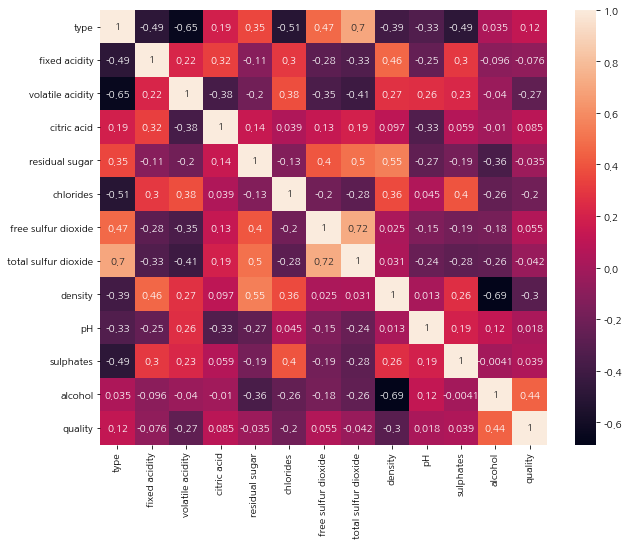

In [16]:
# 상관관계
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot = True)

In [17]:
# 관련있는 특성 추출
data.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [18]:
# 입력데이터 만들기
input_df = data[['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates']]
input_df.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,7.0,0.27,20.7,0.045,45.0,170.0,1.0010,3.00,0.45
1,6.3,0.30,1.6,0.049,14.0,132.0,0.9940,3.30,0.49
2,8.1,0.28,6.9,0.050,30.0,97.0,0.9951,3.26,0.44
3,7.2,0.23,8.5,0.058,47.0,186.0,0.9956,3.19,0.40
4,7.2,0.23,8.5,0.058,47.0,186.0,0.9956,3.19,0.40


In [19]:
input_df.shape

(6463, 9)

In [20]:
# 입력데이터는 2차원 배열로 만들기
input_data = input_df.to_numpy()
input_data

array([[ 7.     ,  0.27   , 20.7    , ...,  1.001  ,  3.     ,  0.45   ],
       [ 6.3    ,  0.3    ,  1.6    , ...,  0.994  ,  3.3    ,  0.49   ],
       [ 8.1    ,  0.28   ,  6.9    , ...,  0.9951 ,  3.26   ,  0.44   ],
       ...,
       [ 6.3    ,  0.51   ,  2.3    , ...,  0.99574,  3.42   ,  0.75   ],
       [ 5.9    ,  0.645  ,  2.     , ...,  0.99547,  3.57   ,  0.71   ],
       [ 6.     ,  0.31   ,  3.6    , ...,  0.99549,  3.39   ,  0.66   ]])

In [21]:
# 타겟데이터 만들기
target_data = data['type'].to_numpy()
target_data

array([1, 1, 1, ..., 0, 0, 0])

## 4-2. 데이터 나누기

In [22]:
from sklearn.model_selection import train_test_split

# 훈련 세트와 테스트 세트 나누기
train_input, test_input, train_target, test_target = train_test_split(input_data, target_data, stratify=target_data, random_state=42)
train_input.shape, test_input.shape

((4847, 9), (1616, 9))

## 4-3. 데이터 전처리 - 표준화

In [23]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

## 4-4. 모델 학습 및 평가

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)

DecisionTreeClassifier(random_state=42)

In [25]:
dt.score(train_scaled, train_target)

0.9995873736331752

In [26]:
dt.score(test_scaled, test_target)

0.9863861386138614

* 훈련세트는 높은데 테스트세트는 낮을 경우 -> 과대 적합
* 훈련세트, 테스트세트 모두 낮을 경우 -> 과소 적합

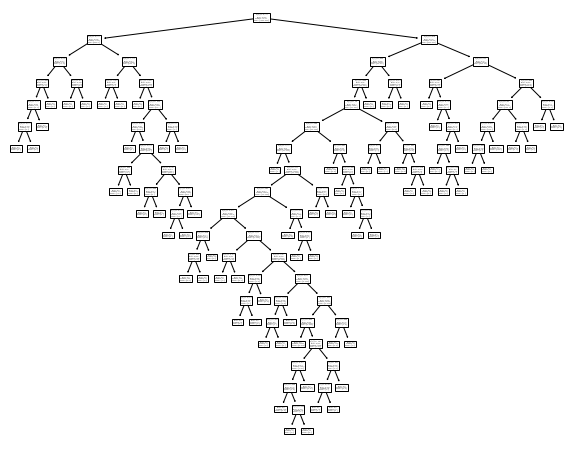

In [27]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 8))
plot_tree(dt)
plt.show()

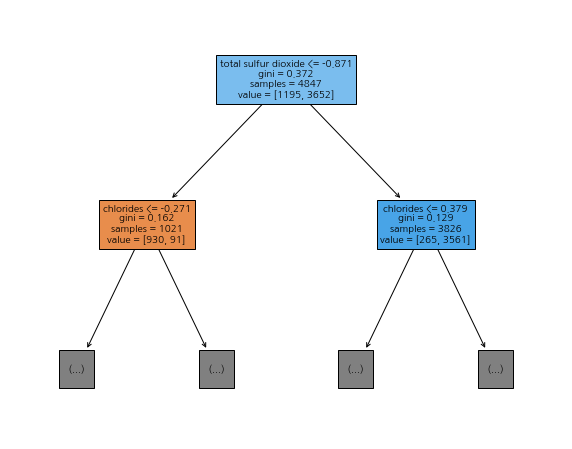

In [28]:
plt.figure(figsize=(10, 8))
plot_tree(dt, max_depth=1, filled=True, feature_names=['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates'])
plt.show()

* 결정트리 : 리프 노드에서 가장 많은 클래스가 예측 클래스가 됨
* 결정트리를 회귀 문제에 적용하면 리프 노드에 도달한 샘플의 타깃값을 평균하여 예측값으로 사용
* 결정트리 분류모델(DecisionTreeClassifier), 결정트리 회귀모델(DecisionTreeRegressor)
* gini : 지니 불순도를 의미, 노드에서 데이터를 분할하는 기준이 되는 값
* 결정트리 모델은 부모 노드와 자식 노드의 불순도 차이가 크도록 트리를 성장시킴
* Depth가 깊어질수록 훈련세트에는 잘 맞지만 테스트세트에서는 안맞는 과대적합이 발생할 수 있음
* 적절히 가지치기를 해야 함 -> 트리의 최대 깊이 지정

In [29]:
# 지니 불순도 = 1 - (음성클래스 비율^2 + 양성클래스비율^2)
1 - ((1195/4847)**2 + (3652/(4847))**2)

0.37152036981946734

In [30]:
1195+3652

4847

In [31]:
# 가지치기
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_scaled, train_target)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [33]:
dt.score(train_scaled, train_target)

0.974004538890035

In [35]:
dt.score(test_scaled, test_target)

0.9721534653465347

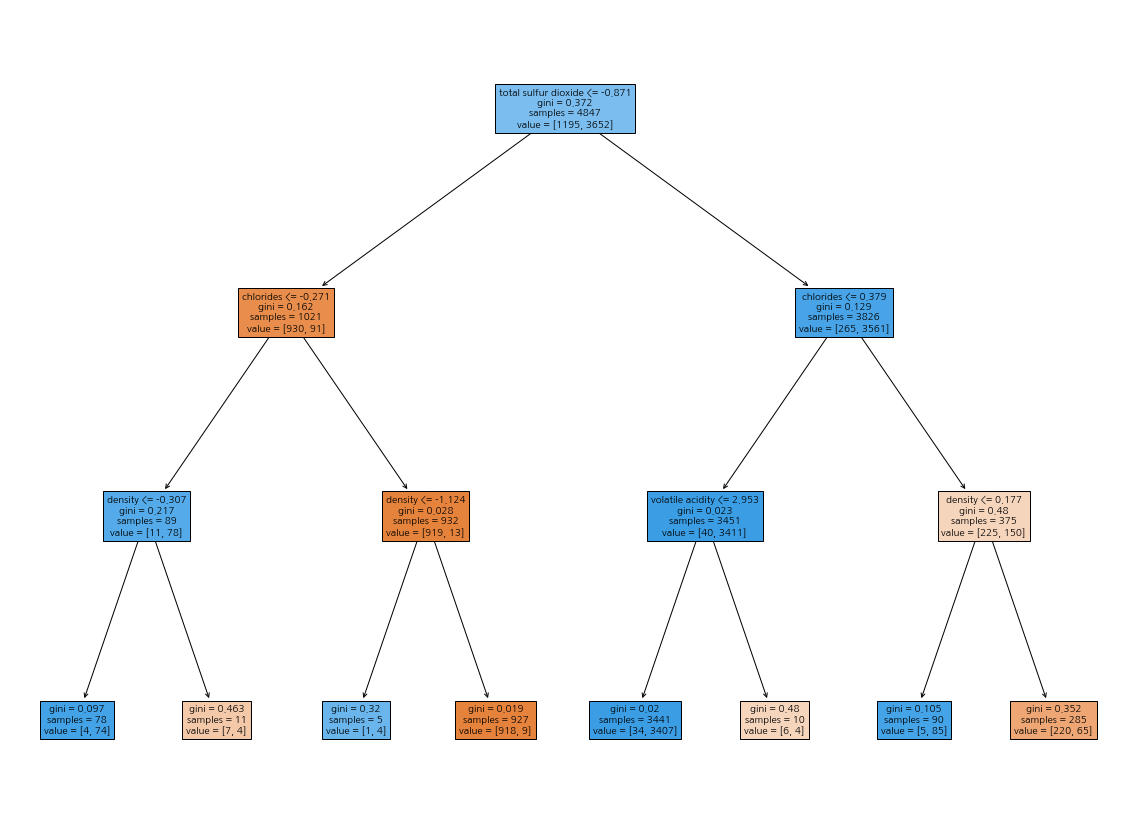

In [42]:
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates'])
plt.show()

In [43]:
# 값이 마이너스가 나온 이유?
# 결정트리 모델에서는 표준화 전처리를 할 필요가 없음
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [44]:
dt.score(train_input, train_target)

0.974004538890035

In [45]:
dt.score(test_input, test_target)

0.9721534653465347

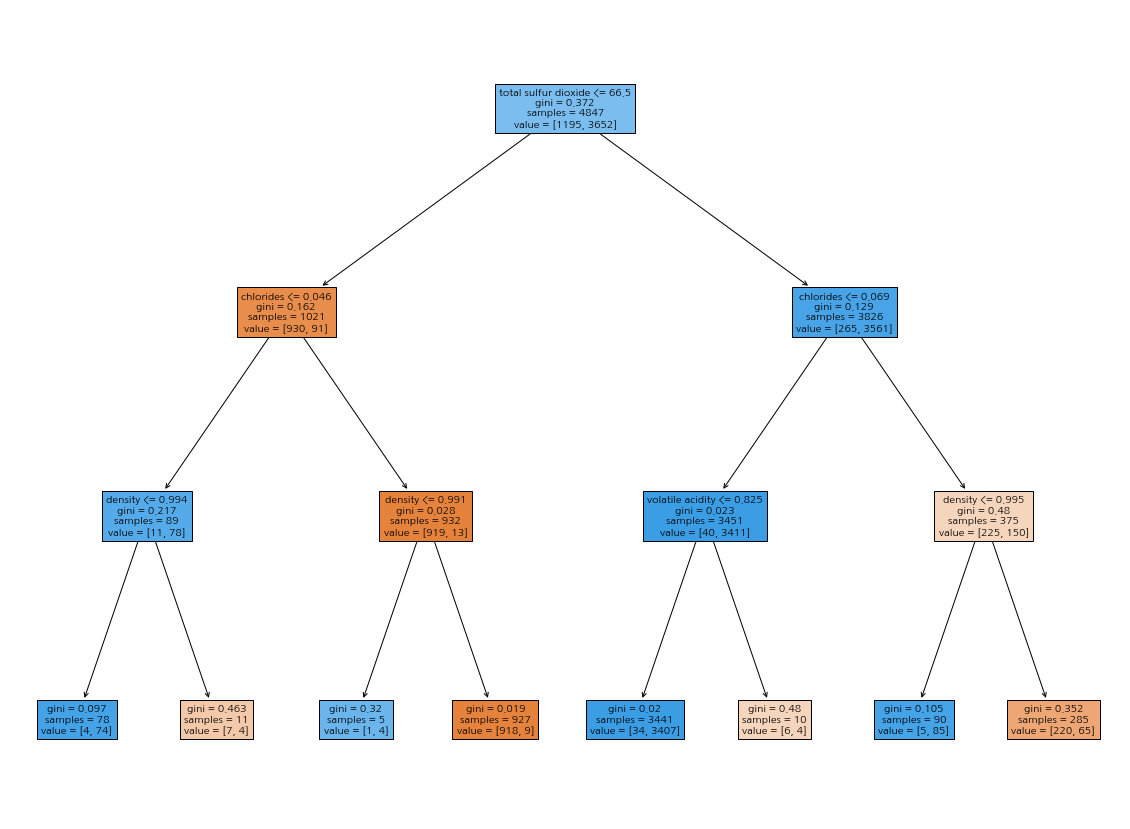

In [46]:
plt.figure(figsize=(20, 15))
plot_tree(dt, filled=True, feature_names=['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates'])
plt.show()

In [47]:
# 특성 중요도 : 어떤 특성이 가장 유용한지
dt.feature_importances_

array([0.        , 0.00437669, 0.        , 0.22377994, 0.        ,
       0.7195238 , 0.05231957, 0.        , 0.        ])

In [48]:
input_df.columns

Index(['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates'],
      dtype='object')

In [ ]:
# 특성 중요도가 0인 특성을 제외하고 다시 학습을 시키면?